In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import tensorflow as tf
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential

In [2]:
img_dir = 'dataset/Medical mask/Medical mask/Medical Mask/images'
train_full = pd.read_csv('dataset/train.csv')
submission = pd.read_csv('dataset/submission.csv')

In [3]:
train_full.head()

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


In [4]:
options = ['face_with_mask','face_no_mask']
train = train_full[train_full['classname'].isin(options)].sort_values('name')

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
# encode classname column since it has only two classes
train['target'] = le.fit_transform(train.classname)
print("Number of unique images in train set: ", train.name.nunique())
train.head()

Number of unique images in train set:  3390


,name,x1,x2,y1,y2,classname,target
13381,1801.jpg,451,186,895,697,face_no_mask,0
3463,1802.jpg,110,71,273,272,face_with_mask,1
14835,1803.jpg,126,75,303,333,face_with_mask,1
5867,1804.jpg,112,113,262,307,face_with_mask,1
6194,1805.jpg,728,180,853,336,face_with_mask,1


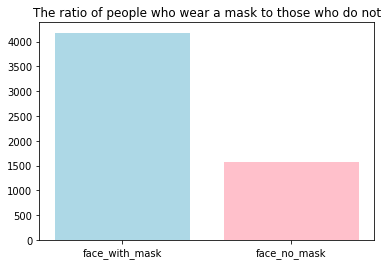

In [5]:
plt.bar(['face_with_mask','face_no_mask'], train.classname.value_counts(), color = ['lightblue','pink']);
plt.title('The ratio of people who wear a mask to those who do not');

In [6]:
print("Number of unique images in submission set: ", submission.name.nunique())
submission.head()

Number of unique images in submission set:  1698


,name,x1,x2,y1,y2,classname
0,1800.jpg,NaN,NaN,NaN,NaN,NaN
1,1800.jpg,NaN,NaN,NaN,NaN,NaN
2,1800.jpg,NaN,NaN,NaN,NaN,NaN
3,1799.jpg,NaN,NaN,NaN,NaN,NaN
4,1799.jpg,NaN,NaN,NaN,NaN,NaN


In [7]:
train_images = train.name.unique().tolist()
test_images = submission.name.unique().tolist()

# Train image sample

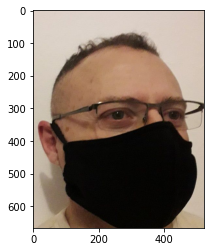

In [8]:
# pick a random index from train_images
i = np.random.choice(np.arange(1801, len(train_images)))
# read image
img = plt.imread(os.path.join(img_dir,train_images[i]))
# plot image
plt.imshow(img)

# Test image sample 

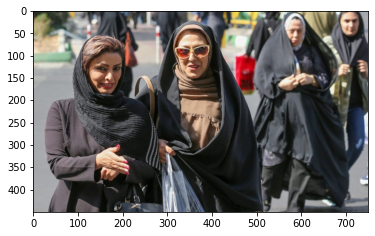

In [9]:
# pick a random index from test_images
i = np.random.choice(len(test_images))
# read image
img = plt.imread(os.path.join(img_dir,test_images[i]))
# plot image
plt.imshow(img)

In [10]:
# create a list that would contain bounding boxes for each face
bounding_box=[]
for i in range(len(train)):
    lst = []
    # extract coordinates of bounding box
    for box in train.iloc[i][["x1",'x2','y1','y2']]:
        lst.append(box)
    bounding_box.append(lst)
    
#add new column with bounding boxes
train["bounding_box"] = bounding_box  

# get boxes for each unique image
def get_boxes(filename):
    boxes = []
    # get bounding_box column for all rows where train["name"] == filename
    for box in train[train["name"] == filename]["bounding_box"]:
        boxes.append(box)
    return boxes

In [42]:
train.head()

,name,x1,x2,y1,y2,classname,target,bounding_box
13381,1801.jpg,451,186,895,697,face_no_mask,0,"[451, 186, 895, 697]"
3463,1802.jpg,110,71,273,272,face_with_mask,1,"[110, 71, 273, 272]"
14835,1803.jpg,126,75,303,333,face_with_mask,1,"[126, 75, 303, 333]"
5867,1804.jpg,112,113,262,307,face_with_mask,1,"[112, 113, 262, 307]"
6194,1805.jpg,728,180,853,336,face_with_mask,1,"[728, 180, 853, 336]"


[[107, 9, 566, 581]]


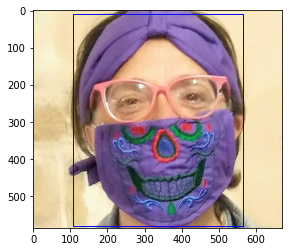

In [11]:
def draw_facebox(image, boxes):
    # plot the image
    plt.imshow(image)
    # get the context for drawing boxes
    ax = plt.gca()
    # plot each box
    for box in boxes:
    # get coordinates
        x, y, width, height = box[0], box[1], box[2], box[3],
        # create the shape
        rect = plt.Rectangle((x, y), width-x, height-y, 
                             fill=False, color='b', linewidth=1)
        # draw the box
        ax.add_patch(rect)
    # show the plot
    plt.show()
    
# pick a random index from train_images
i = np.random.choice(np.arange(1801, len(train_images)))
# read image
image = plt.imread(os.path.join(img_dir,train_images[i]))
# get boxes for image
boxes = get_boxes(train_images[i])
print(boxes)
draw_facebox(image, boxes)

# Create training data

In [12]:
img_size=128
data=[]
for i in range(len(train)):
    x,y,width,height = train.iloc[i]['bounding_box']
    image = train.iloc[i]['name']
    # read image with green channel
    img_array = cv2.imread(os.path.join(img_dir,image), 1)
    # crop image with bounding box
    img_cropped = img_array[y:height,x:width] 
    # resize cropped image
    img = cv2.resize(img_cropped,(img_size,img_size))
    data.append([img,train.iloc[i]['target']])     

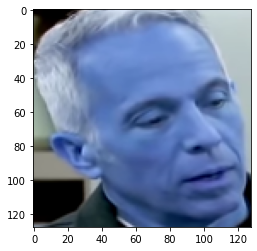

In [13]:
# Pick a random index from data
i = np.random.choice(range(len(data)))
plt.imshow(data[i][0]);

In [14]:
X=[]
Y=[]
for features, labels in data:
    X.append(features)
    Y.append(labels)
X = np.array(X)/255 
print('Shape of X:', X.shape)
Y = np.array(Y)
print('Shape of Y:', Y.shape)

Shape of X: (5749, 128, 128, 3)
Shape of Y: (5749,)


# Build and fit the model

In [15]:
# build the model
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=5, activation="relu", padding='same', input_shape=(128,128,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 128)       0

In [16]:
from sklearn.model_selection import train_test_split
# split our data into train and validation sets
X_train,X_val,y_train,y_val = train_test_split(X, Y,train_size=0.8,random_state=0)

In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
              loss='binary_crossentropy', metrics=['accuracy']) 
# fit the model
history = model.fit(X_train,y_train,batch_size=32,
                 epochs=40,
                 validation_data=(X_val, y_val))

Epoch 1/40
144/144 [==============================] - 57s 392ms/step - loss: 0.5779 - accuracy: 0.7087 - val_loss: 0.3331 - val_accuracy: 0.8617
Epoch 2/40
144/144 [==============================] - 66s 460ms/step - loss: 0.3180 - accuracy: 0.8697 - val_loss: 0.2753 - val_accuracy: 0.8965
Epoch 3/40
144/144 [==============================] - 61s 420ms/step - loss: 0.2770 - accuracy: 0.8810 - val_loss: 0.2567 - val_accuracy: 0.9061
Epoch 4/40
144/144 [==============================] - 57s 394ms/step - loss: 0.2452 - accuracy: 0.8979 - val_loss: 0.2482 - val_accuracy: 0.9026
Epoch 5/40
144/144 [==============================] - 60s 420ms/step - loss: 0.2401 - accuracy: 0.9002 - val_loss: 0.2408 - val_accuracy: 0.9070
Epoch 6/40
144/144 [==============================] - 63s 441ms/step - loss: 0.2244 - accuracy: 0.9078 - val_loss: 0.2173 - val_accuracy: 0.9183
Epoch 7/40
144/144 [==============================] - 58s 402ms/step - loss: 0.2283 - accuracy: 0.9022 - val_loss: 0.2204 - val_ac

Text(0.5, 0, 'Epoch')

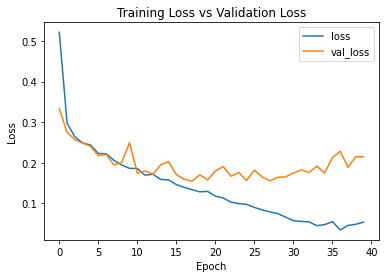

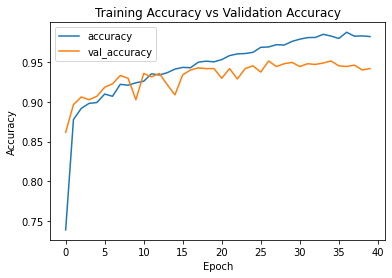

In [18]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

# Preprocessing test images

In [19]:
def draw_facebox(image, boxes):
    # plot the image
    plt.imshow(image)
    # get the context for drawing boxes
    ax = plt.gca()
    # plot each box
    for box in boxes:
    # get coordinates
        x, y, width, height = box[0], box[1], box[2], box[3],
        # create the shape
        rect = plt.Rectangle((x, y), width, height, 
                             fill=False, color='r', linewidth=1)
        # draw the box
        ax.add_patch(rect)
    # show the plot
    plt.show()


### Plot a random image from with bounding box(es)

In [20]:
from mtcnn.mtcnn import MTCNN
detector = MTCNN()
names = []
bboxes = []
# create lists which would contain filenames of images and bounding boxes
for img_name in test_images:
    # load image from file
    image = plt.imread(os.path.join(img_dir, img_name))
    # detect faces in the image
    faces = detector.detect_faces(image)
    for face in faces: 
        if face['confidence']>0.99:
            names.append(img_name)
            bboxes.append(face['box'])
df = pd.DataFrame({'name' : names, 'bounding_box' : bboxes})
df.head()

,name,bounding_box
0,1800.jpg,"[957, 461, 242, 324]"
1,1796.jpg,"[933, 207, 232, 298]"
2,1796.jpg,"[728, 177, 84, 107]"
3,1796.jpg,"[470, 223, 185, 229]"
4,1795.jpg,"[687, 3, 41, 48]"


[[109, 243, 83, 97], [250, 126, 85, 90], [7, 104, 71, 79], [933, 249, 72, 84], [715, 114, 78, 91], [422, 262, 129, 139]]


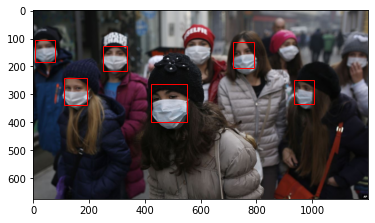

In [21]:
i = np.random.choice(len(test_images))
# load image from file
image = plt.imread(os.path.join(img_dir, df.name[i]))
# detect faces in the image
faces = detector.detect_faces(image)
boxes = [face['box'] for face in faces if face['confidence']>0.99]
print(boxes)
# display faces on the original image
draw_facebox(image, boxes)

In [22]:
data=[]
for i in range(len(df)):
    # replace any negative value with zero
    x,y,width,height = [0 if value < 0 else value for value in df.iloc[i]['bounding_box']]
    image = df.iloc[i]['name']
    # read image with green channel
    img_array = cv2.imread(os.path.join(img_dir,image), 1)
    # crop image with bounding box
    img_cropped = img_array[y:y+height,x:x+width]  
    # resize cropped image
    img = cv2.resize(img_cropped,(img_size,img_size))
    data.append(img)

# Predict classes

In [23]:
X = np.array(data)/255
predict = model.predict(X)
df['classname'] = ['face_with_mask' if i > 0.8 else 'face_with_no_mask' for i in predict]
df

,name,bounding_box,classname
0,1800.jpg,"[957, 461, 242, 324]",face_with_no_mask
1,1796.jpg,"[933, 207, 232, 298]",face_with_mask
2,1796.jpg,"[728, 177, 84, 107]",face_with_no_mask
3,1796.jpg,"[470, 223, 185, 229]",face_with_mask
4,1795.jpg,"[687, 3, 41, 48]",face_with_no_mask
...,...,...,...
1957,0011.jpg,"[203, 71, 65, 86]",face_with_no_mask
1958,0011.jpg,"[406, 106, 70, 97]",face_with_no_mask
1959,0006.jpg,"[441, 668, 57, 70]",face_with_no_mask
1960,0004.jpg,"[631, 175, 212, 264]",face_with_mask


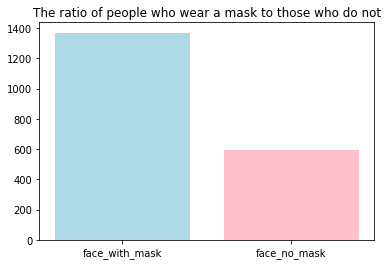

In [24]:
plt.bar(['face_with_mask','face_no_mask'], df.classname.value_counts(), color = ['lightblue','pink']);
plt.title('The ratio of people who wear a mask to those who do not');

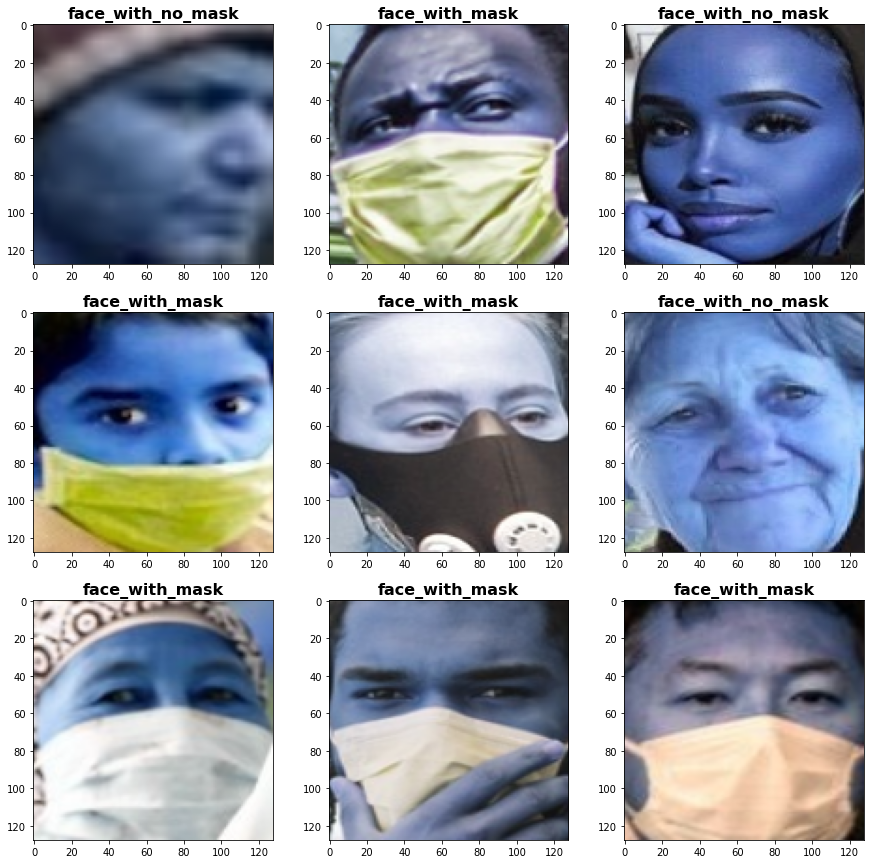

In [25]:
# choose 9 random indexes from df.index
indexes = np.random.choice(df.index, 9)

fig, axes = plt.subplots(nrows=3, ncols=3) 
i = 0
fig.set_figheight(15)
fig.set_figwidth(15)
for row in axes:
    for col in row:
        # plot the cropped image
        col.imshow(data[indexes[i]])
        col.set_title(df.iloc[indexes[i]]['classname'],fontsize=16,fontweight='bold' )
        i+=1
plt.show()

In [26]:
# save the result to csv
df.to_csv('submission_1.csv')

In [27]:
model.save('trained_model.h5', history)